<a href="https://colab.research.google.com/github/minsmis/NaverAI/blob/main/notebooks/1%EC%A3%BC/5%EC%B0%A8%EC%8B%9C/%ED%8A%B8%EB%A6%AC_%EB%AA%A8%EB%8D%B8_%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [5차시] 트리 모델 연습

* 세번째 베이스라인 모델은 LightGBM을 사용한 두번째 베이스라인 모델과 동일한 피처를 사용합니다.
* Cross Validation Out Of Fold Prediction으로 모델의 Validation 성능을 측정하고, Test 데이터 예측 기능을 추가합니다.

## Function 정의

- seed_everything() : seed 고정 함수
- generate_label() : label 생성 함수
- print_score() : 평가지표 출력 함수
- feature_preprocessing() : 데이터 전처리 함수(label encoding, 결측치 처리)
- feature_engineering1() : 피처 엔지니어링 함수
- make_lgb_oof_prediction() : LightGBM cross validation out of fold train/predict 함수
- plot_feature_importances() : LightGBM 피처 중요도 플롯 함수

## Library Import

In [1]:
# Suppress warnings
import warnings

warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random
from typing import List

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

## Fix Seed 함수 정의

In [2]:
'''
    결과의 재현성을 위해 seed 값을 설정하는 함수
'''


def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


SEED = 42
seed_everything(SEED)

## 레이블 생성 함수 정의

- 레이블 생성 함수는 연월을 인자로 받아서 고객 아이디별로 총 구매액이 인자로 받는 구매액 임계값을 넘는지 여부를 바이너리 레이블로 생성하는 함수

In [3]:
TOTAL_THRES = 300

'''
    입력인자로 받는 year_month에 대해 고객 ID별로 총 구매액이
    구매액 임계값을 넘는지 여부의 binary label을 생성하는 함수
'''


def generate_label(df, year_month, total_thres=TOTAL_THRES, print_log=False):
    df = df.copy()

    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month'] < year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month'] == year_month]

    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id': cust})
    label['year_month'] = year_month

    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id', 'year_month'], as_index=False)[['total']].sum()

    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id', 'year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')

    return label

## 평가지표 출력 함수 정의

In [4]:
'''
    평가지표를 출력하는 함수
'''


def print_score(label: List[float], pred: List[float], prob_thres: float = 0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred > prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred > prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred > prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

## 데이터 전처리 함수 정의
- 범주형 변수 레이블 인코딩
- 결측치 중위값으로 채움

In [5]:
'''
    입력인자로 받는 train, test 데이터에 대해 범주형 피쳐는 레이블 인코딩을
    진행하고 결측치에 대해서는 중위값으로 데이터 전처리를 하는 함수
'''


def feature_preprocessing(
        train: pd.DataFrame,
        test: pd.DataFrame,
        features: list,
        do_imputing=True
):
    x_tr = train.copy()
    x_te = test.copy()

    # 범주형 피처 이름을 저장할 변수
    cate_cols = []

    # 레이블 인코딩
    for f in features:
        if x_tr[f].dtype.name == 'object':  # 데이터 타입이 object(str)이면 레이블 인코딩
            cate_cols.append(f)
            le = LabelEncoder()
            # train + test 데이터를 합쳐서 레이블 인코딩 함수에 fit
            le.fit(list(x_tr[f].values) + list(x_te[f].values))

            # train 데이터 레이블 인코딩 변환 수행
            x_tr[f] = le.transform(list(x_tr[f].values))

            # test 데이터 레이블 인코딩 변환 수행
            x_te[f] = le.transform(list(x_te[f].values))

    print('categorical feature:', cate_cols)

    if do_imputing:
        # 중위값으로 결측치 채우기
        imputer = SimpleImputer(strategy='median')

        x_tr[features] = imputer.fit_transform(x_tr[features])
        x_te[features] = imputer.transform(x_te[features])

    return x_tr, x_te

## 피처 엔지니어링 함수 정의
- Pandas groupby aggregation 함수를 사용한 피처 엔지니어링

In [17]:
'''
    입력인자로 받는 year_month와 변수 prev_ym 기준으로 train, test 데이터를 생성 하고
    집계(aggregation) 함수를 사용하여 피처 엔지니어링을 하는 함수
'''


def feature_engineering1(df: pd.DataFrame, year_month: str):
    df = df.copy()

    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')

    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]

    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id', 'year_month', 'label']]
    test_label = generate_label(df, year_month)[['customer_id', 'year_month', 'label']]

    # group by aggregation 함수 선언
    agg_func = ['mean', 'max', 'min', 'sum', 'count', 'std', 'skew']
    all_train_data = pd.DataFrame()

    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train.loc[train['order_date'] < tr_ym, ['customer_id', 'price', 'quantity', 'total']].groupby(
            ['customer_id']).agg(agg_func)

        # 멀티 레벨 컬럼을 사용하기 쉽게 1 레벨 컬럼명으로 변경
        new_cols = []
        for col in train_agg.columns.levels[0]:
            for stat in train_agg.columns.levels[1]:
                new_cols.append(f'{col}-{stat}')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace=True)

        train_agg['year_month'] = tr_ym

        all_train_data = all_train_data._append(train_agg)

    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns

    # group by aggretation 함수로 test 데이터 피처 생성
    test_agg = test[['customer_id', 'price', 'quantity', 'total']].groupby(['customer_id']).agg(agg_func)
    test_agg.columns = new_cols

    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')

    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)

    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)

    return x_tr, x_te, all_train_data['label'], features

## LightGBM cross validation out of fold train/predict 함수 정의

In [19]:
'''
    학습 데이터(x_tr), 검증 데이터(x_val), 테스트 데이터(test)로 LightGBM 모델을
    학습, 교차(cross) 검증 및 테스트하고 사용된 피처들의 중요도를 반환하는 함수
'''


def make_lgb_oof_prediction(train, y, test, features, categorical_features='auto', model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]

    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])

    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])

    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0

    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features

    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]

        print(f'fold: {fold + 1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)

        # LightGBM 모델 훈련
        clf = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid],  # Validation 성능을 측정할 수 있도록 설정
            categorical_feature=categorical_features,
            # verbose_eval=200
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_val)

        # Validation index에 예측값 저장
        y_oof[val_idx] = val_preds

        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-' * 80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds

        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(x_test) / folds

        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold + 1}'] = clf.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()

    print(f"\nMean AUC = {score}")  # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}")  # Out Of Fold Validation 스코어 출력

    # 폴드별 피처 중요도 평균값 계산해서 저장
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)

    return y_oof, test_preds, fi

## LightGBM 피처 중요도 플롯 함수 정의

In [8]:
'''
    피처 중요도 정규화(importance_normalized) 및 누적 중요도(cumulative_importance)를 계산하고
    중요도 정규화 순으로 n개의 바플롯을 그리는 함수
'''


def plot_feature_importances(df, n=20, color='blue', figsize=(12, 8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending=False).reset_index(drop=True)

    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized',
                            x='feature', color=color,
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18);
    plt.ylabel('');
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()

    return df

## Train 데이터 읽기
- 9개의 feature를 가진 780502개의 train data

In [9]:
data = pd.read_csv("./input/train.csv", parse_dates=["order_date"])
print(data.shape)  # data shape 확인
data.head()

(780502, 9)


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


## Pandas info() 함수로 데이터 타입 및 null 체크

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780502 non-null  object        
 1   product_id   780502 non-null  object        
 2   description  780502 non-null  object        
 3   quantity     780502 non-null  int64         
 4   order_date   780502 non-null  datetime64[ns]
 5   price        780502 non-null  float64       
 6   customer_id  780502 non-null  int64         
 7   country      780502 non-null  object        
 8   total        780502 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 53.6+ MB


## Pandas isna(), sum() 함수로 null 데이터 개수 체크

In [11]:
data.isna().sum()

order_id       0
product_id     0
description    0
quantity       0
order_date     0
price          0
customer_id    0
country        0
total          0
dtype: int64

## Pandas describe() 함수에 include='all' 인자 설정으로 수치형, 범주형 데이터 기본 통계량 확인

In [12]:
data.describe(include='all')

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
count,780502,780502,780502,780502.000000,780502,780502.000000,780502.000000,780502,780502.000000
unique,43955,4645,5297,NaN,NaN,NaN,NaN,41,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom,NaN
freq,542,5096,5096,NaN,NaN,NaN,NaN,700317,NaN
mean,NaN,NaN,NaN,12.623307,2010-12-26 01:08:30.093324288,6.140931,15313.393466,NaN,33.715373
min,NaN,NaN,NaN,-74215.000000,2009-12-01 07:45:00,0.000000,12346.000000,NaN,-127352.940000
25%,NaN,NaN,NaN,2.000000,2010-06-29 11:10:00,2.062500,13963.000000,NaN,7.260000
50%,NaN,NaN,NaN,5.000000,2010-11-28 13:40:00,3.217500,15239.000000,NaN,19.470000
75%,NaN,NaN,NaN,12.000000,2011-07-18 11:55:00,6.187500,16788.000000,NaN,32.175000
max,NaN,NaN,NaN,74215.000000,2011-11-30 17:42:00,64300.500000,18287.000000,NaN,127352.940000


## 2011년 11월 Label 데이터 생성

In [13]:
label_2011_11 = generate_label(data, '2011-11')['label']

## Label 데이터 분포 플롯

label
0    4534
1    1188
Name: count, dtype: int64

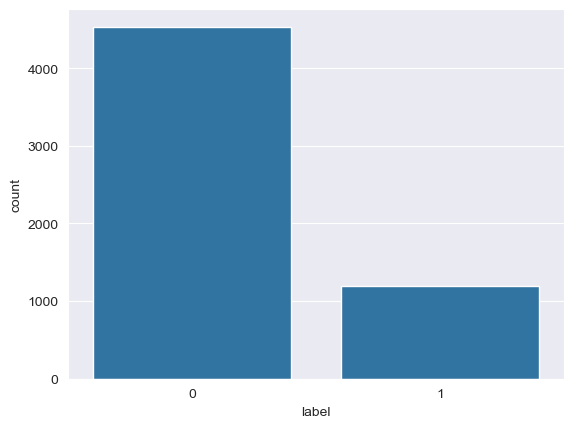

In [14]:
sns.countplot(x=label_2011_11)
label_2011_11.value_counts()

## LightGBM Hyperparameter 선언
- early stopping 기능을 사용하기 위해 n_estimators, early_stopping_rounds 설정

In [15]:
model_params = {
    'objective': 'binary',  # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc',  # 평가 지표 설정
    'feature_fraction': 0.8,  # 피처 샘플링 비율
    'bagging_fraction': 0.8,  # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 10000,  # 트리 개수
    'early_stopping_rounds': 100,
    'seed': SEED,
    'verbose': -1,
    'n_jobs': -1,
}

## 2011년 11월 베이스라인 모델 예측
- Validation 성능 측정

In [20]:
train, test, y, features = feature_engineering1(data, '2011-11')
y_oof, test_preds_2011_11, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)
print_score(label_2011_11, test_preds_2011_11)

categorical feature: []
x_tr.shape (5501, 24) , x_te.shape (5722, 24)
fold: 1, x_tr.shape: (4950, 21), x_val.shape: (551, 21)
Fold 1 | AUC: 0.7462142197599261
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (4951, 21), x_val.shape: (550, 21)
Fold 2 | AUC: 0.8233249346771183
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (4951, 21), x_val.shape: (550, 21)
Fold 3 | AUC: 0.7518313736468831
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (4951, 21), x_val.shape: (550, 21)
Fold 4 | AUC: 0.7920282754759238
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (4951, 21), x_val.shape: (550, 21)
Fold 5 | AUC: 0.7729329973870848
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (4951, 21), x_val.shape: (550, 21)
Fold 6 | AUC: 0.77892870

## 2011년 11월 베이스라인 모델 예측 데이터 분포

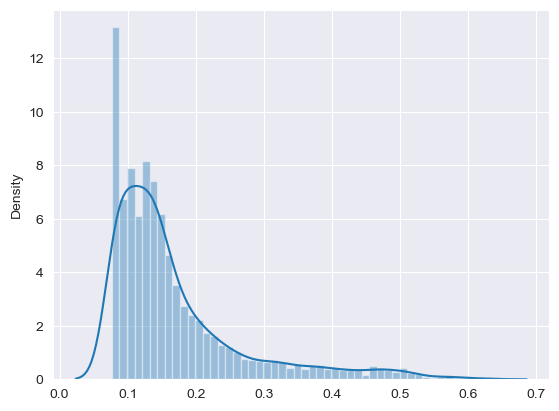

In [21]:
sns.distplot(test_preds_2011_11)
plt.show()

## 2011년 12월 베이스라인 모델 예측
- 테스트 데이터 제출

In [22]:
train, test, y, features = feature_engineering1(data, '2011-12')
y_oof, test_preds, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)

categorical feature: []
x_tr.shape (5722, 24) , x_te.shape (5914, 24)
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7661033576426165
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7972365157516752
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7878742626745314
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7440733965504367
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7751497950173447
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 6 | AUC: 0.78787541

## 2011년 12월 베이스라인 모델 예측 데이터 분포

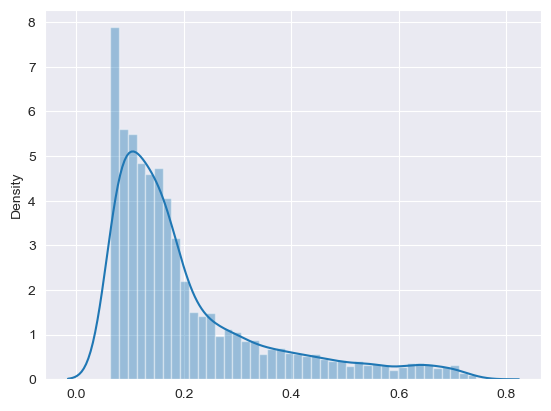

In [23]:
sns.distplot(test_preds)
plt.show()

## 피처 중요도 플롯

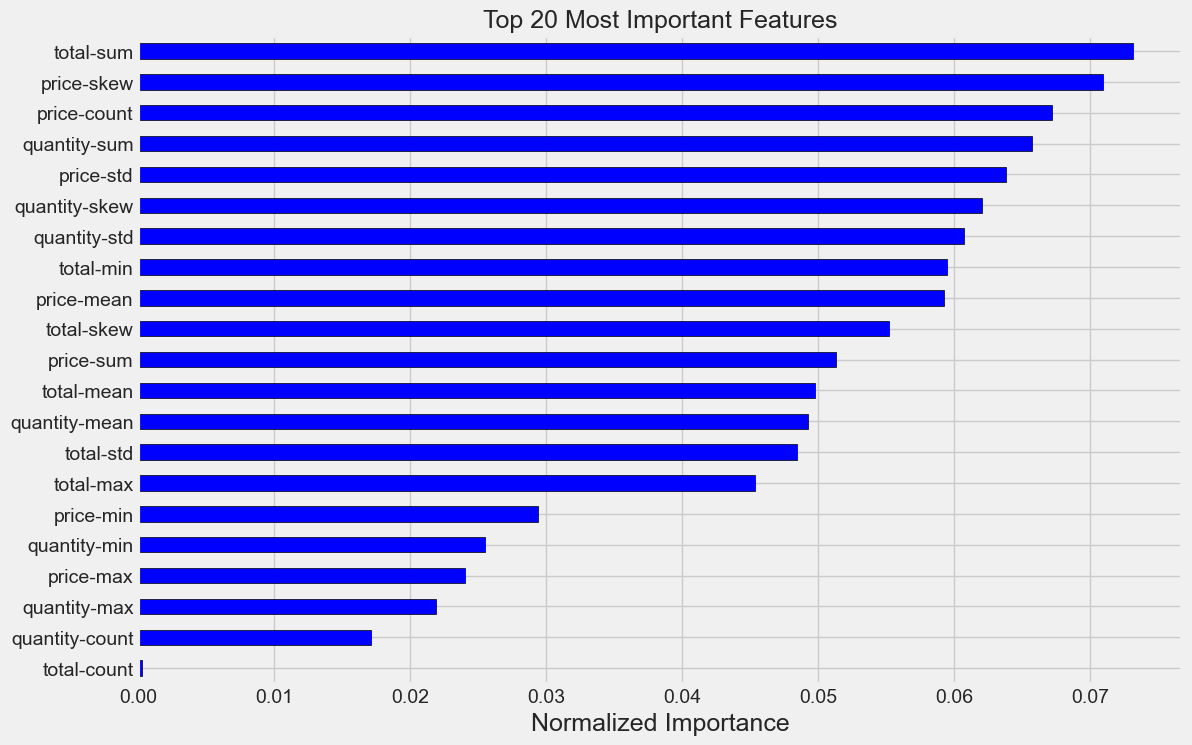

In [24]:
fi = plot_feature_importances(fi)

ALL RIGHTS RESERVED. (C)NAVER Connect Foundation.